In [42]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch
import numpy as np
import tomllib
from oversampler import oversample_dataframe
from imblearn.over_sampling import RandomOverSampler

from mads_hackathon import datasets, metrics

First, go to the `config.toml` file and change the `dev` value to your name. Please use `firstname_lastname` format. 
In addition to that, change the `port` value to the port of your team.

In [31]:

configfile = Path("config.toml")
with configfile.open("rb") as f:
    tomlconfig = tomllib.load(f)

assert tomlconfig["dev"] != "dev", ValueError("Please set dev in config.toml to your own name")
assert tomlconfig["port"] != "none", ValueError("Please set port in config.toml to your own port")
uri = tomlconfig["mlflow_uri"] + ":" + tomlconfig["port"]
dev = tomlconfig["dev"]
print(f"Using {uri} as mlfow uri")
print(f"Using {dev} as dev name")

Using http://145.38.195.42:5004 as mlfow uri
Using Geertjan as dev name


Load the datasets

In [47]:
datadir = Path('../hackathon-data/')
trainfile = (datadir / "heart_big_train.parq").resolve()
validfile = (datadir / "heart_big_valid.parq").resolve()
trainfile.exists(), validfile.exists()

(True, True)

In [48]:
df = pd.read_parquet(trainfile)
x = df.drop(columns=["target"])  # All columns except target
y = df["target"]  # Target column

    # Initialize the oversampler
oversampler = RandomOverSampler(sampling_strategy="not majority", random_state=42)
    
    # Apply oversampling
x_resampled, y_resampled = oversampler.fit_resample(x, y)
    
    # Combine oversampled features and target back into a DataFrame
df_resampled = pd.concat([pd.DataFrame(x_resampled, columns=x.columns), 
                            pd.Series(y_resampled, name="target")], axis=1)
    
df_resampled.to_parquet("../hackathon-data/oversampled_heart_big_train.parq", engine='pyarrow')

In [49]:
datadir = Path('../hackathon-data/')
trainfile = (datadir / "oversampled_heart_big_train.parq").resolve()
validfile = (datadir / "heart_big_valid.parq").resolve()
trainfile.exists(), validfile.exists()

(True, True)

Change the backend, if you have one.

In [50]:
import torch
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using MPS")
elif torch.cuda.is_available():
    device = "cuda:0"
    print("using cuda")
else:
    device = "cpu"
    print("using cpu")

using cpu


Change the 1D data into a 2D matrix with the HeartDataset2D class. See `src/mads_hackathon/datasets.py` for more information.

In [51]:
matrixshape = (4, 48)

traindataset = datasets.HeartDataset2D(trainfile, target="target", shape=matrixshape)
testdataset = datasets.HeartDataset2D(validfile, target="target", shape=matrixshape)
traindataset.to(device)
testdataset.to(device)




Let's see how that works. 
Compare this to the 1D data from notebook `01_explore-heart.ipynb`

(torch.Size([1, 4, 48]), tensor(0))

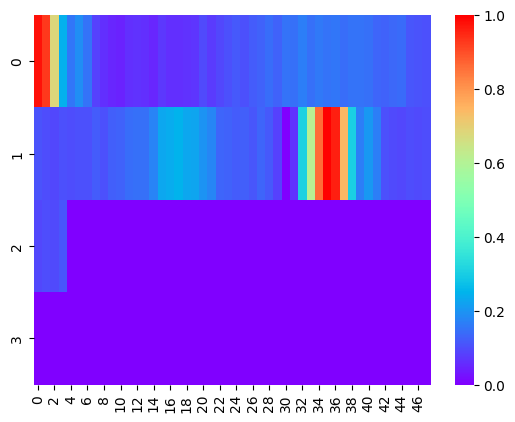

In [52]:
x, y = traindataset[0]
# Assuming your tensor is named 'tensor'
viz = x.squeeze().cpu().numpy()
sns.heatmap(viz, cmap='rainbow')
x.shape, y

First, we set the config, then load into a streamer

In [53]:
from mads_hackathon.models import CNNConfig as Config

config = Config(
    matrixshape = (4,48),
    batchsize = 64,
    input_channels = 1,
    hidden = 16,
    kernel_size = 3,
    maxpool = 2,
    num_layers = 1,
    num_classes = 5,
)
config

CNNConfig(matrixshape=(4, 48), batchsize=64, input_channels=1, hidden=16, kernel_size=3, maxpool=2, num_layers=1, num_classes=5)

In [54]:
trainstreamer = BaseDatastreamer(traindataset, preprocessor = BasePreprocessor(), batchsize=config.batchsize)
teststreamer = BaseDatastreamer(testdataset, preprocessor = BasePreprocessor(), batchsize=config.batchsize)
len(trainstreamer), len(teststreamer)

(5661, 171)

Let's check the shape

In [55]:
x, y = next(trainstreamer.stream())
x.shape, y.shape

(torch.Size([64, 1, 4, 48]), torch.Size([64]))

We can load the CNN model. It uses a ConvBlock class that is a wrapper around a Conv2D and ReLU stack.
The ConvBlock makes it easier to stack block in the CNN model, see `src/mads_hackathon/models.py` for the implementation.

This is just a initial setup: please experiment with other architectures like:
- adding ideas like resnet, googlenet, squeeze-excite, etc.
- add additional layers like dropout, batchnorm, etc.
- experiment with different ways to go from 4D to 2D tensors

In [56]:
from mads_hackathon.models import CNN
model = CNN(config)

Calculated matrix size: 48
Caluclated flatten size: 768


Let's check the architecture

In [57]:
from torchinfo import summary
summary(model, input_size=(config.batchsize, 1, *config.matrixshape))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [64, 5]                   --
├─ModuleList: 1-1                        --                        --
│    └─ConvBlock: 2-1                    [64, 16, 4, 48]           --
│    │    └─Sequential: 3-1              [64, 16, 4, 48]           2,480
│    └─ConvBlock: 2-2                    [64, 16, 4, 48]           --
│    │    └─Sequential: 3-2              [64, 16, 4, 48]           4,640
│    └─ReLU: 2-3                         [64, 16, 4, 48]           --
│    └─MaxPool2d: 2-4                    [64, 16, 2, 24]           --
├─Sequential: 1-2                        [64, 5]                   --
│    └─Flatten: 2-5                      [64, 768]                 --
│    └─Linear: 2-6                       [64, 16]                  12,304
│    └─ReLU: 2-7                         [64, 16]                  --
│    └─Linear: 2-8                       [64, 5]                   85
Total

And test if the model works

In [58]:
model.to(device)
yhat = model(x)
yhat.shape

torch.Size([64, 5])

The data is unbalanced, so we are interested in much more than just accuracy.
See https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html for more information on the F1 micro/macro score.
See `src/mads_hackathon/metrics.py` for the implementation. You might want to add more metrics, or change the settings for `average`

In [59]:
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision(average='macro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()
print(f1micro)

F1scoremicro


We also want a confusion matrix to see how the model is performing on the different classes.

In [60]:
from mads_hackathon.metrics import caluclate_cfm

We set the mlflow server to log the results

In [61]:
import mlflow
mlflow.set_tracking_uri(uri)
mlflow.set_experiment("test1")

<Experiment: artifact_location='mlflow-artifacts:/938617144803771077', creation_time=1732531054629, experiment_id='938617144803771077', last_update_time=1732531054629, lifecycle_stage='active', name='test1', tags={}>

In [62]:
config = Config(
    matrixshape = (4,48),
    batchsize = 64,
    input_channels = 1,
    hidden = 16,
    kernel_size = 3,
    maxpool = 2,
    num_layers = 1,
    num_classes = 5,
)
config

CNNConfig(matrixshape=(4, 48), batchsize=64, input_channels=1, hidden=16, kernel_size=3, maxpool=2, num_layers=1, num_classes=5)

Please dont just run the cell below, but walk trough what is being logged.
For example, you might want to change the tag for the model and the dataset if you make changes there, and 
to the scheduler/earlystop if you are using it.

2024-11-25 14:36:25.662 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart2D/20241125-143625
100%|██████████| 5661/5661 [01:14<00:00, 75.65it/s] 
2024-11-25 14:37:42.097 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.3471 test 0.2981 metric ['0.9042', '0.9042', '0.7106', '0.6835', '0.9015']
100%|██████████| 5661/5661 [01:15<00:00, 74.96it/s] 
2024-11-25 14:38:59.560 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.1796 test 0.3803 metric ['0.8758', '0.8758', '0.6788', '0.6415', '0.9086']
100%|██████████| 5661/5661 [01:35<00:00, 59.10it/s]
2024-11-25 14:40:37.088 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.1317 test 0.2466 metric ['0.9237', '0.9237', '0.7396', '0.7202', '0.9166']
100%|██████████| 5661/5661 [01:13<00:00, 76.60it/s] 
2024-11-25 14:41:53.054 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.1012 test 0.2135 metric ['0.9409', '0.9409', '0.7762', '0.7598', '0.9232']
100%|██████████| 5661/5661 [01:26<0

🏃 View run righteous-shrimp-710 at: http://145.38.195.42:5004/#/experiments/938617144803771077/runs/b2edf7121e764293b3c9a24f0bd3689f
🧪 View experiment at: http://145.38.195.42:5004/#/experiments/938617144803771077


[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

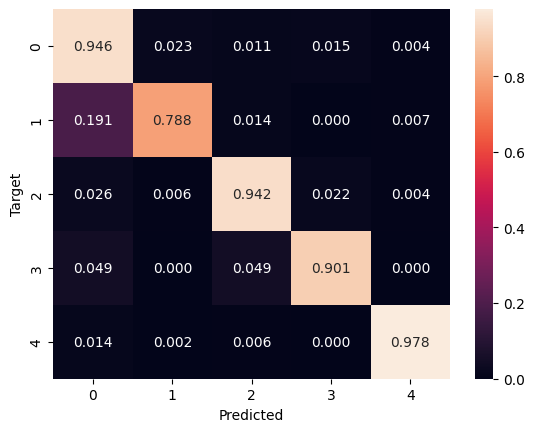

In [63]:
from mltrainer import Trainer, TrainerSettings, ReportTypes
from dataclasses import asdict
loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=5,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart2D",
        train_steps=len(trainstreamer),
        valid_steps=len(teststreamer),
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs=None,
        earlystop_kwargs=None
    )

    # modify the tags when you change them!
    mlflow.set_tag("model", "CNN")
    mlflow.set_tag("dataset", "heart2D")
    mlflow.set_tag("dev", dev)
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")

    mlflow.log_params(asdict(config))
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("matrix0", config.matrixshape[0])
    mlflow.log_param("matrix1", config.matrixshape[1])
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=None,
        device=device,
        )
    trainer.loop()
    cfm = caluclate_cfm(model, teststreamer)
    for i, tp in enumerate(np.diag(cfm)):
        mlflow.log_metric(f"TP_{i}", tp)

plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")

Please note that, while the TP score for class 0 does get high without much effort, the challenge here will be in the other classes that lag behind.